In [14]:
import numpy as np
import gym
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import trange

In [15]:
class ReplayBuffer:
    rng = np.random.default_rng()

    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = self.rng.choice(self.size, batch_size)
        return [self.buffer[index] for index in indices]

In [16]:
class NeuralNet(nn.Module):
    def __init__(self, neurons=32, input=3, output=1):
        super().__init__()  # This line needs to called to properly setup the network
        # Layer with 'input' inputs and `neurons` output
        self.linear1 = nn.Linear(input, neurons)
        self.act1 = nn.ReLU()  # Activation function
        self.linear2 = nn.Linear(neurons, neurons)
        self.act2 = nn.ReLU()  # Activation function
        # Layer with `neurons` inputs and 'output' outputs
        self.linear3 = nn.Linear(neurons, output)

    def forward(self, x):

        x = self.linear1(x)
        x = self.act1(x)

        x = self.linear2(x)
        x = self.act2(x)

        out = self.linear3(x)

        return out

In [17]:
def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

In [18]:
# Import and initialize the discrete Lunar Laner Environment
env = gym.make('LunarLander-v2')
env.reset()

# Parameters
N_episodes = 200                             # Number of episodes
discount_factor = 0.9                      # Value of the discount factor
n_ep_running_average = 50                    # Running average of 50 episodes
n_actions = env.action_space.n               # Number of available actions
dim_state = len(env.observation_space.high)  # State dimensionality

max_size = 10000                             # Maximum length of replay buffer
train_batch = 32                             # Amount of experiences in a batch
update_freq = int(max_size/train_batch)      # Update frequency of target network
lr = 1e-3                                    # Learning rate
clip_val = 1                                 # Gradient clipping value
epsilon_max = 0.9                            # Exploration parameter max,min
epsilon_min = 0.05
start_annealing = 0.2*N_episodes             # Percentage of episodes when learning starts
stop_annealing = 0.8*N_episodes
neurons = 32
 

# We will use these variables to compute the average episodic reward and
# the average number of steps per episode
episode_reward_list = []       # this list contains the total reward per episode
episode_number_of_steps = []   # this list contains the number of steps per episode



In [19]:
class Agent(object):
      ''' Base agent class, used as a parent class

          Args:
              n_actions (int): number of actions

          Attributes:
              n_actions (int): where we store the number of actions
              last_action (int): last action taken by the agent
      '''
      def __init__(self, n_actions: int):
          self.n_actions = n_actions
          self.last_action = None

      def forward(self, state: np.ndarray):
          ''' Performs a forward computation '''
          pass

      def backward(self):
          ''' Performs a backward pass on the network '''
          pass


class RandomAgent(Agent):
      ''' Agent taking actions uniformly at random, child of the class Agent'''
      def __init__(self, n_actions: int):
          super(RandomAgent, self).__init__(n_actions)

      def forward(self, state: np.ndarray) -> int:
          ''' Compute an action uniformly at random across n_actions possible
              choices

              Returns:
                  action (int): the random action
          '''
          self.last_action = np.random.randint(0, self.n_actions)
          return self.last_action

class DQNAgent(Agent):
      """
      DQN agent using two neural networks to make decisions
      """
      def __init__(self, neurons, n_actions, dim_state, lr, discount_factor, batch_size, clip_val):
          super(DQNAgent, self).__init__(n_actions)
          self.rng = np.random.default_rng()
          self.network = NeuralNet(neurons, input=dim_state, output=n_actions)
          self.target = NeuralNet(neurons, input=dim_state, output=n_actions)
          self.lr = lr
          self.discount_factor = discount_factor
          self.buffer = ReplayBuffer(max_size=max_size)
          self.opt = torch.optim.Adam(self.network.parameters(), lr=self.lr)
          self.batch_size = batch_size
          self.clip_val = clip_val
        
      def forward(self, state, epsilon):
          self.epsilon = epsilon
          if self.rng.choice([0,1], p=[1-self.epsilon, self.epsilon]):
            self.last_action = self.rng.choice(self.n_actions)
            return self.last_action
          # Create state tensor and feed to main network to generate action
          state_tensor = torch.tensor(np.array([state]), requires_grad=True)

          output_tensor = self.network(state_tensor)

          self.last_action = output_tensor.max(1)[1].item()
          return self.last_action

      def backward(self):
          if self.buffer.size < self.batch_size:
            return
          # Perform learning step for the network
          # Reset gradients
          self.opt.zero_grad()
          batch = self.buffer.sample(self.batch_size)

          # Get a batch of Q(s_t, a_t) for every (s_t, a_t) in batch
          x = torch.tensor(np.array([exp['state'] for exp in batch]), requires_grad=True)
          x = self.network(x)
          x = torch.tensor([x[i, exp['action']] for i, exp in enumerate(batch)], requires_grad=True)

          # Get targets for the batch
          y = torch.tensor(np.array([exp['next_state'] for exp in batch]), requires_grad=True)
          y = self.target(y)

          # Indicator of whether episode finished with each experience
          d = torch.tensor(
                np.array([not exp['done'] for exp in batch]), requires_grad=False)
          # Reward for each experience
          r = torch.tensor(np.array([exp['reward'] for exp in batch]), requires_grad=False)
          # Target values are r if the episode terminates in an experience, 
          # and are r + gamma*max_a Q(s_t,a) if not
          y = r + self.discount_factor*d*y.max(1)[0]
          y = y.float()

          # Calculate MSE loss and perform backward step
          loss = nn.functional.mse_loss(x, y)
          loss.backward()
          nn.utils.clip_grad_norm_(self.network.parameters(), self.clip_val)
          self.opt.step()
      
      def update_target(self):
          # Copy parameters to target network
          self.target.load_state_dict(self.network.state_dict())

In [20]:
### Training process

# trange is an alternative to range in python, from the tqdm library
# It shows a nice progression bar that you can update with useful information
#agent = RandomAgent(n_actions)
agent = DQNAgent(neurons, n_actions, dim_state, lr, discount_factor, train_batch, clip_val)
EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
steps = 0
eps_list = []
for i in EPISODES:
    # Reset enviroment data and initialize variables
    done = False
    state = env.reset()
    total_episode_reward = 0.
    t = 0
    while not done:

        # Calculate epsilon value, linear annealing
        if i >= round(start_annealing):
          epsilon = max(epsilon_min, epsilon_max - (epsilon_max-epsilon_min)*(i-start_annealing)/(stop_annealing-start_annealing-1))
        else:
          epsilon = epsilon_max
        
        # Take a random action
        action = agent.forward(state, epsilon)

        # Get next state and reward.  The done variable
        # will be True if you reached the goal position,
        # False otherwise
        next_state, reward, done, _ = env.step(action)

        # Append experience to buffer
        experience = {'state':state, 'action':action, 'reward':reward, 'next_state':next_state, 'done':done}
        agent.buffer.append(experience)

        # Update episode reward
        total_episode_reward += reward
        
        # Perform learning step for the agent
        agent.backward()

        # Update target if enough steps have passed
        if steps % update_freq == 0 and steps!=0:
          agent.update_target()

        # Update state for next iteration
        state = next_state
        t+= 1
        steps+=1

    # Append episode reward and total number of steps
    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)
    eps_list.append(epsilon)

    # Close environment
    env.close()

    # Updates the tqdm update bar with fresh information
    # (episode number, total reward of the last episode, total number of Steps
    # of the last episode, average reward, average number of steps)
    EPISODES.set_description(
        "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
        i, total_episode_reward, t,
        running_average(episode_reward_list, n_ep_running_average)[-1],
        running_average(episode_number_of_steps, n_ep_running_average)[-1]))


Episode 199 - Reward/Steps: -666.0/90 - Avg. Reward/Steps: -264.7/76: 100%|██████████| 200/200 [00:25<00:00,  7.84it/s]


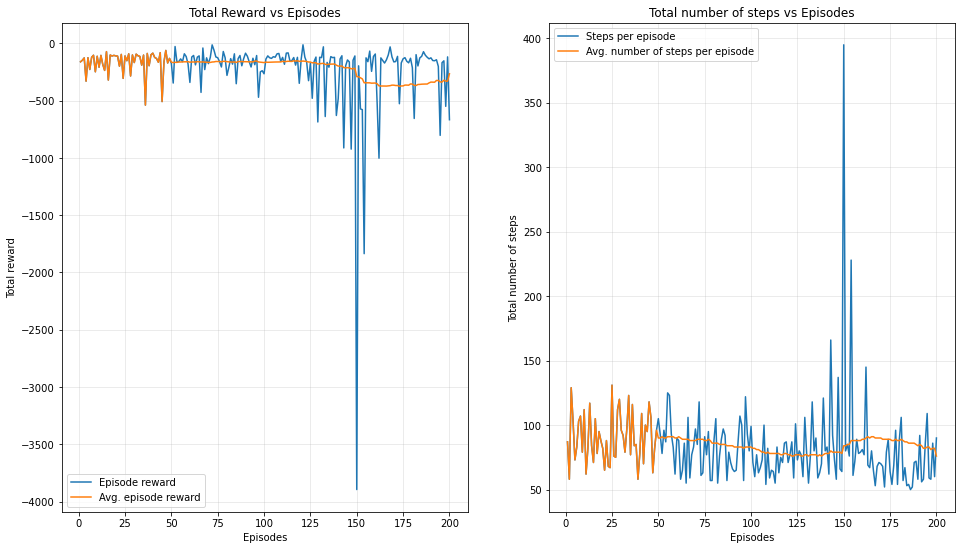

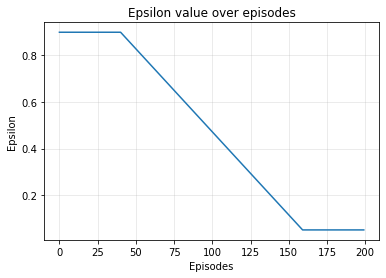

In [21]:
# Plot Rewards and steps
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.figure()
plt.plot(eps_list)
plt.title("Epsilon value over episodes")
plt.ylabel("Epsilon")
plt.xlabel("Episodes")
plt.grid(alpha=0.3)
plt.show()